## Required Libraries

In [10]:
import pandas as pd
import numpy as np
import glob
import math
from math import sqrt
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import gridspec
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
plt.style.use('default')
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller


from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas.plotting import autocorrelation_plot

import pingouin as pg
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.layers import LSTM, Flatten, Dropout


from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from keras.optimizers import Adam
import time


In [2]:
lstm_data = pd.read_csv('/Users/asur18/Desktop/MSc_Project_Data/My_Appoach/Data/LSTM.csv')

# Convert the 'Date' column to datetime
def convert_to_datetime(df):
    try:
        df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
    except:
        df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%y')
    return df

lstm_data = convert_to_datetime(lstm_data)

## Normalize Data

In [3]:
lstm_data = lstm_data[['Date','Water Column']]
lstm_data.set_index('Date',inplace=True)

# # Get the 'Water Column' values and reshape them to a 2D array
values = lstm_data['Water Column'].values.reshape(-1, 1)

# # Normalize the data to the range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(values)



## Setting the random seeds for reproducibility and reshaping data for LSTM 


In [4]:
# Setting the random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define the lookback period
look_back = 5

# Reshape the data into sequences with a lookback period of 5
def create_sequences(data, look_back):
    X, Y = [], []
    for i in range(len(data)-look_back):
        a = data[i:(i+look_back), :]
        X.append(a)
        Y.append(data[i+look_back, 0])  # Predict the next water level
    return np.array(X), np.array(Y)

X, y = create_sequences(scaled_data, look_back)

In [5]:
# Split the reshaped data into training and testing datasets
split_index = int(0.85 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Print the shape of the reshaped data
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (83, 5, 1)
Shape of y_train: (83,)
Shape of X_test: (15, 5, 1)
Shape of y_test: (15,)


## Defining the performance metrics

    - NSE (Nash Sutcliffe Efficiency)
    - RMSE(Root Mean Squared Error)
    - MAPE (Mean Absolute percentage Error)

In [6]:
def nash_sutcliffe_efficiency(observed, predicted):
    """
    Compute the Nash-Sutcliffe Efficiency.

    Parameters:
    - observed : list or array-like
        List or array of observed values
    - predicted : list or array-like
        List or array of predicted values

    Returns:
    - nse : float
        Nash-Sutcliffe Efficiency
    """
    observed_mean = np.mean(observed)
    numerator = np.sum((observed - predicted) ** 2)
    denominator = np.sum((observed - observed_mean) ** 2)
    nse = 1 - (numerator / denominator)
    return nse

In [7]:
import numpy as np

def mean_absolute_percentage_error(observed, predicted):
    """
    Compute the Mean Absolute Percentage Error.

    Parameters:
    - observed : list or array-like
        List or array of observed values
    - predicted : list or array-like
        List or array of predicted values

    Returns:
    - mape : float
        Mean Absolute Percentage Error
    """
    # Calculate the absolute percentage error for each data point
    absolute_percentage_error = np.abs((observed - predicted) / observed)

    # Calculate the mean of the absolute percentage errors
    mape = 100 * np.mean(absolute_percentage_error)

    return mape

## Developing the Model Archtitecture

In [8]:
def run_loop(learning_rate, num_units, dropout_rate, batch_size, loop, num_epochs):
    
    for i in range(loop):
        
        # Start time capture
        start_time = time.time()
        
        # Define the LSTM model
        model = Sequential()
        # Add the first LSTM layer
        model.add(LSTM(num_units, input_shape=(look_back, 1), kernel_initializer='glorot_uniform'))
        model.add(Dense(1,kernel_initializer='glorot_uniform'))
        optimizer = Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='mean_squared_error')

        # Train the model with validation data set to the test set
        history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, shuffle=False, verbose=2, validation_data=(X_test, y_test))

        # Display the model summary
        model.summary()

        # Evaluate the model on the validation data
        validation_loss = model.evaluate(X_test, y_test)
        print(f"Validation Loss: {validation_loss}")


        # putting the model to make predictions on the training and validation data
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)


        # Reshaping the data to inverse transform
        train_pred_reshaped = np.zeros((len(train_pred), X_train.shape[2]))
        train_pred_reshaped[:,0] = train_pred[:,0].reshape(-1)
        test_pred_reshaped = np.zeros((len(test_pred), X_test.shape[2]))
        test_pred_reshaped[:,0] = test_pred[:,0].reshape(-1)

        # Inverse transform the predictions
        train_pred_original = scaler.inverse_transform(train_pred_reshaped)[:,0]
        test_pred_original = scaler.inverse_transform(test_pred_reshaped)[:,0]

        # Inverse transform the target values
        y_train_original = scaler.inverse_transform(np.hstack((y_train.reshape(-1,1), np.zeros((y_train.shape[0], X_train.shape[2]-1)))))[:,0]
        y_test_original = scaler.inverse_transform(np.hstack((y_test.reshape(-1,1), np.zeros((y_test.shape[0], X_test.shape[2]-1)))))[:,0]

        # Calculate the performance metrics
        mape_train = mean_absolute_percentage_error(y_train_original, train_pred_original)
        rmse_train = np.sqrt(mean_squared_error(y_train_original, train_pred_original))
        nse_train = nash_sutcliffe_efficiency(y_train_original, train_pred_original)

        mape_test = mean_absolute_percentage_error(y_test_original, test_pred_original)
        rmse_test = np.sqrt(mean_squared_error(y_test_original, test_pred_original))
        nse_test = nash_sutcliffe_efficiency(y_test_original, test_pred_original)
        
        # End time capture
        end_time = time.time()
        # Calculate elapsed time
        elapsed_time = end_time - start_time

        results.append((model, {"train_pred_original": train_pred_original, "test_pred_original": test_pred_original, "y_train_original": y_train_original, "y_test_original": y_test_original, "mape_train": mape_train, "rmse_train": rmse_train, "nse_train": nse_train, "mape_test": mape_test, "rmse_test": rmse_test, "nse_test": nse_test, "elapsed_time": elapsed_time}))
        
        

## Executing the model with 100 Iteration

In [11]:
results = []
# run_loop(lr, num_units, dropout_rate, batch_size, loop, num_epochs):
run_loop(0.001, 50, 0.0, 16, 100, 50)

2023-09-01 02:49:02.513956: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
6/6 - 2s - loss: 0.2900 - val_loss: 0.0013 - 2s/epoch - 341ms/step
Epoch 2/50
6/6 - 0s - loss: 0.1676 - val_loss: 0.0037 - 46ms/epoch - 8ms/step
Epoch 3/50
6/6 - 0s - loss: 0.0815 - val_loss: 0.0124 - 44ms/epoch - 7ms/step
Epoch 4/50
6/6 - 0s - loss: 0.0295 - val_loss: 0.0259 - 42ms/epoch - 7ms/step
Epoch 5/50
6/6 - 0s - loss: 0.0126 - val_loss: 0.0365 - 42ms/epoch - 7ms/step
Epoch 6/50
6/6 - 0s - loss: 0.0140 - val_loss: 0.0355 - 39ms/epoch - 7ms/step
Epoch 7/50
6/6 - 0s - loss: 0.0116 - val_loss: 0.0274 - 41ms/epoch - 7ms/step
Epoch 8/50
6/6 - 0s - loss: 0.0085 - val_loss: 0.0204 - 41ms/epoch - 7ms/step
Epoch 9/50
6/6 - 0s - loss: 0.0089 - val_loss: 0.0165 - 42ms/epoch - 7ms/step
Epoch 10/50
6/6 - 0s - loss: 0.0097 - val_loss: 0.0150 - 41ms/epoch - 7ms/step
Epoch 11/50
6/6 - 0s - loss: 0.0091 - val_loss: 0.0145 - 41ms/epoch - 7ms/step
Epoch 12/50
6/6 - 0s - loss: 0.0080 - val_loss: 0.0139 - 41ms/epoch - 7ms/step
Epoch 13/50
6/6 - 0s - loss: 0.0073 - val_loss: 0.0127 - 42ms

Epoch 44/50
6/6 - 0s - loss: 0.0056 - val_loss: 0.0012 - 40ms/epoch - 7ms/step
Epoch 45/50
6/6 - 0s - loss: 0.0056 - val_loss: 0.0012 - 38ms/epoch - 6ms/step
Epoch 46/50
6/6 - 0s - loss: 0.0056 - val_loss: 0.0012 - 39ms/epoch - 6ms/step
Epoch 47/50
6/6 - 0s - loss: 0.0056 - val_loss: 0.0012 - 38ms/epoch - 6ms/step
Epoch 48/50
6/6 - 0s - loss: 0.0056 - val_loss: 0.0012 - 40ms/epoch - 7ms/step
Epoch 49/50
6/6 - 0s - loss: 0.0056 - val_loss: 0.0012 - 38ms/epoch - 6ms/step
Epoch 50/50
6/6 - 0s - loss: 0.0056 - val_loss: 0.0012 - 39ms/epoch - 6ms/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                10400     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,451
Trainabl

Epoch 26/50
6/6 - 0s - loss: 0.0050 - val_loss: 0.0016 - 38ms/epoch - 6ms/step
Epoch 27/50
6/6 - 0s - loss: 0.0050 - val_loss: 0.0014 - 38ms/epoch - 6ms/step
Epoch 28/50
6/6 - 0s - loss: 0.0049 - val_loss: 0.0013 - 39ms/epoch - 7ms/step
Epoch 29/50
6/6 - 0s - loss: 0.0049 - val_loss: 0.0012 - 38ms/epoch - 6ms/step
Epoch 30/50
6/6 - 0s - loss: 0.0049 - val_loss: 0.0012 - 38ms/epoch - 6ms/step
Epoch 31/50
6/6 - 0s - loss: 0.0049 - val_loss: 0.0011 - 38ms/epoch - 6ms/step
Epoch 32/50
6/6 - 0s - loss: 0.0049 - val_loss: 0.0011 - 38ms/epoch - 6ms/step
Epoch 33/50
6/6 - 0s - loss: 0.0049 - val_loss: 0.0011 - 38ms/epoch - 6ms/step
Epoch 34/50
6/6 - 0s - loss: 0.0049 - val_loss: 0.0011 - 38ms/epoch - 6ms/step
Epoch 35/50
6/6 - 0s - loss: 0.0049 - val_loss: 0.0011 - 38ms/epoch - 6ms/step
Epoch 36/50
6/6 - 0s - loss: 0.0049 - val_loss: 0.0011 - 39ms/epoch - 6ms/step
Epoch 37/50
6/6 - 0s - loss: 0.0049 - val_loss: 0.0011 - 38ms/epoch - 6ms/step
Epoch 38/50
6/6 - 0s - loss: 0.0049 - val_loss: 0.00

Epoch 8/50
6/6 - 0s - loss: 0.0127 - val_loss: 0.0365 - 36ms/epoch - 6ms/step
Epoch 9/50
6/6 - 0s - loss: 0.0097 - val_loss: 0.0286 - 39ms/epoch - 6ms/step
Epoch 10/50
6/6 - 0s - loss: 0.0101 - val_loss: 0.0239 - 41ms/epoch - 7ms/step
Epoch 11/50
6/6 - 0s - loss: 0.0109 - val_loss: 0.0219 - 59ms/epoch - 10ms/step
Epoch 12/50
6/6 - 0s - loss: 0.0104 - val_loss: 0.0211 - 262ms/epoch - 44ms/step
Epoch 13/50
6/6 - 0s - loss: 0.0093 - val_loss: 0.0204 - 67ms/epoch - 11ms/step
Epoch 14/50
6/6 - 0s - loss: 0.0085 - val_loss: 0.0190 - 53ms/epoch - 9ms/step
Epoch 15/50
6/6 - 0s - loss: 0.0080 - val_loss: 0.0170 - 91ms/epoch - 15ms/step
Epoch 16/50
6/6 - 1s - loss: 0.0077 - val_loss: 0.0148 - 605ms/epoch - 101ms/step
Epoch 17/50
6/6 - 2s - loss: 0.0075 - val_loss: 0.0129 - 2s/epoch - 278ms/step
Epoch 18/50
6/6 - 1s - loss: 0.0073 - val_loss: 0.0114 - 1s/epoch - 187ms/step
Epoch 19/50
6/6 - 2s - loss: 0.0071 - val_loss: 0.0102 - 2s/epoch - 265ms/step
Epoch 20/50
6/6 - 2s - loss: 0.0068 - val_loss

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 50)                10400     
                                                                 
 dense_6 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 30ms/step - loss: 0.0012
Validation Loss: 0.001165503985248506
1/1 [==============================] - 0s 22ms/step
Epoch 1/50
6/6 - 2s - loss: 0.3862 - val_loss: 0.0016 - 2s/epoch - 406ms/step
Epoch 2/50
6/6 - 0s - loss: 0.2356 - val_loss: 0.0025 - 53ms/epoch - 9ms/step
Epoch 3/50
6/6 - 0s - loss: 0.1296 - val_loss: 0.0085 - 59ms/epoch - 10ms/step
Epoch 4/50
6/6 - 0s - loss: 0.0577 - val_loss: 0.0192 

Epoch 33/50
6/6 - 0s - loss: 0.0048 - val_loss: 0.0012 - 35ms/epoch - 6ms/step
Epoch 34/50
6/6 - 0s - loss: 0.0048 - val_loss: 0.0012 - 35ms/epoch - 6ms/step
Epoch 35/50
6/6 - 0s - loss: 0.0048 - val_loss: 0.0012 - 35ms/epoch - 6ms/step
Epoch 36/50
6/6 - 0s - loss: 0.0048 - val_loss: 0.0012 - 35ms/epoch - 6ms/step
Epoch 37/50
6/6 - 0s - loss: 0.0048 - val_loss: 0.0012 - 35ms/epoch - 6ms/step
Epoch 38/50
6/6 - 0s - loss: 0.0048 - val_loss: 0.0013 - 35ms/epoch - 6ms/step
Epoch 39/50
6/6 - 0s - loss: 0.0048 - val_loss: 0.0013 - 35ms/epoch - 6ms/step
Epoch 40/50
6/6 - 0s - loss: 0.0048 - val_loss: 0.0013 - 35ms/epoch - 6ms/step
Epoch 41/50
6/6 - 0s - loss: 0.0048 - val_loss: 0.0013 - 35ms/epoch - 6ms/step
Epoch 42/50
6/6 - 0s - loss: 0.0048 - val_loss: 0.0013 - 35ms/epoch - 6ms/step
Epoch 43/50
6/6 - 0s - loss: 0.0047 - val_loss: 0.0013 - 36ms/epoch - 6ms/step
Epoch 44/50
6/6 - 0s - loss: 0.0047 - val_loss: 0.0013 - 35ms/epoch - 6ms/step
Epoch 45/50
6/6 - 0s - loss: 0.0047 - val_loss: 0.00

Epoch 15/50
6/6 - 0s - loss: 0.0078 - val_loss: 0.0153 - 36ms/epoch - 6ms/step
Epoch 16/50
6/6 - 0s - loss: 0.0075 - val_loss: 0.0134 - 36ms/epoch - 6ms/step
Epoch 17/50
6/6 - 0s - loss: 0.0073 - val_loss: 0.0117 - 36ms/epoch - 6ms/step
Epoch 18/50
6/6 - 0s - loss: 0.0071 - val_loss: 0.0104 - 36ms/epoch - 6ms/step
Epoch 19/50
6/6 - 0s - loss: 0.0069 - val_loss: 0.0093 - 35ms/epoch - 6ms/step
Epoch 20/50
6/6 - 0s - loss: 0.0067 - val_loss: 0.0083 - 35ms/epoch - 6ms/step
Epoch 21/50
6/6 - 0s - loss: 0.0064 - val_loss: 0.0073 - 35ms/epoch - 6ms/step
Epoch 22/50
6/6 - 0s - loss: 0.0063 - val_loss: 0.0064 - 36ms/epoch - 6ms/step
Epoch 23/50
6/6 - 0s - loss: 0.0062 - val_loss: 0.0056 - 36ms/epoch - 6ms/step
Epoch 24/50
6/6 - 0s - loss: 0.0061 - val_loss: 0.0049 - 36ms/epoch - 6ms/step
Epoch 25/50
6/6 - 0s - loss: 0.0060 - val_loss: 0.0043 - 36ms/epoch - 6ms/step
Epoch 26/50
6/6 - 0s - loss: 0.0059 - val_loss: 0.0038 - 36ms/epoch - 6ms/step
Epoch 27/50
6/6 - 0s - loss: 0.0058 - val_loss: 0.00

Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 22ms/step - loss: 0.0012
Validation Loss: 0.0011593399103730917
1/1 [==============================] - 0s 19ms/step
Epoch 1/50
6/6 - 2s - loss: 0.2635 - val_loss: 0.0013 - 2s/epoch - 286ms/step
Epoch 2/50
6/6 - 0s - loss: 0.1581 - val_loss: 0.0029 - 42ms/epoch - 7ms/step
Epoch 3/50
6/6 - 0s - loss: 0.0827 - val_loss: 0.0092 - 41ms/epoch - 7ms/step
Epoch 4/50
6/6 - 0s - loss: 0.0335 - val_loss: 0.0198 - 36ms/epoch - 6ms/step
Epoch 5/50
6/6 - 0s - loss: 0.0128 - val_loss: 0.0301 - 36ms/epoch - 6ms/step
Epoch 6/50
6/6 - 0s - loss: 0.0120 - val_loss: 0.0321 - 36ms/epoch - 6ms/step
Epoch 7/50
6/6 - 0s - loss: 0.0115 - val_loss: 0.0264 - 36ms/epoch - 6ms/step
Epoch 8/50
6/6 - 0s - loss: 0.0084 - val_loss: 0.0199 - 38ms/epoch - 6ms/step
Epoch 9/50
6/6 - 0s - loss: 0.0081 - val_loss: 0.0158 - 36ms/epoch - 6ms/step
Epoc

Epoch 40/50
6/6 - 0s - loss: 0.0049 - val_loss: 0.0011 - 36ms/epoch - 6ms/step
Epoch 41/50
6/6 - 0s - loss: 0.0049 - val_loss: 0.0011 - 36ms/epoch - 6ms/step
Epoch 42/50
6/6 - 0s - loss: 0.0049 - val_loss: 0.0011 - 36ms/epoch - 6ms/step
Epoch 43/50
6/6 - 0s - loss: 0.0049 - val_loss: 0.0011 - 39ms/epoch - 7ms/step
Epoch 44/50
6/6 - 0s - loss: 0.0049 - val_loss: 0.0011 - 50ms/epoch - 8ms/step
Epoch 45/50
6/6 - 0s - loss: 0.0049 - val_loss: 0.0012 - 42ms/epoch - 7ms/step
Epoch 46/50
6/6 - 0s - loss: 0.0049 - val_loss: 0.0012 - 46ms/epoch - 8ms/step
Epoch 47/50
6/6 - 0s - loss: 0.0049 - val_loss: 0.0012 - 41ms/epoch - 7ms/step
Epoch 48/50
6/6 - 0s - loss: 0.0049 - val_loss: 0.0012 - 37ms/epoch - 6ms/step
Epoch 49/50
6/6 - 0s - loss: 0.0049 - val_loss: 0.0012 - 37ms/epoch - 6ms/step
Epoch 50/50
6/6 - 0s - loss: 0.0049 - val_loss: 0.0012 - 37ms/epoch - 6ms/step
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape 

Epoch 22/50
6/6 - 0s - loss: 0.0075 - val_loss: 0.0138 - 36ms/epoch - 6ms/step
Epoch 23/50
6/6 - 0s - loss: 0.0073 - val_loss: 0.0124 - 36ms/epoch - 6ms/step
Epoch 24/50
6/6 - 0s - loss: 0.0070 - val_loss: 0.0111 - 37ms/epoch - 6ms/step
Epoch 25/50
6/6 - 0s - loss: 0.0069 - val_loss: 0.0098 - 37ms/epoch - 6ms/step
Epoch 26/50
6/6 - 0s - loss: 0.0067 - val_loss: 0.0087 - 36ms/epoch - 6ms/step
Epoch 27/50
6/6 - 0s - loss: 0.0065 - val_loss: 0.0078 - 37ms/epoch - 6ms/step
Epoch 28/50
6/6 - 0s - loss: 0.0064 - val_loss: 0.0069 - 37ms/epoch - 6ms/step
Epoch 29/50
6/6 - 0s - loss: 0.0063 - val_loss: 0.0062 - 37ms/epoch - 6ms/step
Epoch 30/50
6/6 - 0s - loss: 0.0062 - val_loss: 0.0055 - 37ms/epoch - 6ms/step
Epoch 31/50
6/6 - 0s - loss: 0.0061 - val_loss: 0.0049 - 37ms/epoch - 6ms/step
Epoch 32/50
6/6 - 0s - loss: 0.0061 - val_loss: 0.0043 - 37ms/epoch - 6ms/step
Epoch 33/50
6/6 - 0s - loss: 0.0060 - val_loss: 0.0039 - 37ms/epoch - 6ms/step
Epoch 34/50
6/6 - 0s - loss: 0.0060 - val_loss: 0.00

Epoch 4/50
6/6 - 0s - loss: 0.0805 - val_loss: 0.0157 - 39ms/epoch - 6ms/step
Epoch 5/50
6/6 - 0s - loss: 0.0318 - val_loss: 0.0290 - 37ms/epoch - 6ms/step
Epoch 6/50
6/6 - 0s - loss: 0.0132 - val_loss: 0.0402 - 38ms/epoch - 6ms/step
Epoch 7/50
6/6 - 0s - loss: 0.0135 - val_loss: 0.0411 - 38ms/epoch - 6ms/step
Epoch 8/50
6/6 - 0s - loss: 0.0124 - val_loss: 0.0340 - 38ms/epoch - 6ms/step
Epoch 9/50
6/6 - 0s - loss: 0.0091 - val_loss: 0.0266 - 38ms/epoch - 6ms/step
Epoch 10/50
6/6 - 0s - loss: 0.0091 - val_loss: 0.0221 - 37ms/epoch - 6ms/step
Epoch 11/50
6/6 - 0s - loss: 0.0099 - val_loss: 0.0200 - 37ms/epoch - 6ms/step
Epoch 12/50
6/6 - 0s - loss: 0.0096 - val_loss: 0.0193 - 37ms/epoch - 6ms/step
Epoch 13/50
6/6 - 0s - loss: 0.0087 - val_loss: 0.0187 - 37ms/epoch - 6ms/step
Epoch 14/50
6/6 - 0s - loss: 0.0079 - val_loss: 0.0175 - 37ms/epoch - 6ms/step
Epoch 15/50
6/6 - 0s - loss: 0.0074 - val_loss: 0.0157 - 45ms/epoch - 8ms/step
Epoch 16/50
6/6 - 0s - loss: 0.0071 - val_loss: 0.0138 - 4

Epoch 47/50
6/6 - 0s - loss: 0.0058 - val_loss: 0.0012 - 39ms/epoch - 7ms/step
Epoch 48/50
6/6 - 0s - loss: 0.0058 - val_loss: 0.0012 - 39ms/epoch - 7ms/step
Epoch 49/50
6/6 - 0s - loss: 0.0058 - val_loss: 0.0012 - 39ms/epoch - 7ms/step
Epoch 50/50
6/6 - 0s - loss: 0.0058 - val_loss: 0.0012 - 39ms/epoch - 7ms/step
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 50)                10400     
                                                                 
 dense_18 (Dense)            (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 22ms/step - loss: 0.0012
Validation Loss: 0.0011803555535152555
1/1 [==================

Epoch 29/50
6/6 - 0s - loss: 0.0056 - val_loss: 0.0027 - 38ms/epoch - 6ms/step
Epoch 30/50
6/6 - 0s - loss: 0.0055 - val_loss: 0.0024 - 38ms/epoch - 6ms/step
Epoch 31/50
6/6 - 0s - loss: 0.0055 - val_loss: 0.0021 - 37ms/epoch - 6ms/step
Epoch 32/50
6/6 - 0s - loss: 0.0055 - val_loss: 0.0019 - 39ms/epoch - 6ms/step
Epoch 33/50
6/6 - 0s - loss: 0.0055 - val_loss: 0.0018 - 39ms/epoch - 6ms/step
Epoch 34/50
6/6 - 0s - loss: 0.0055 - val_loss: 0.0016 - 37ms/epoch - 6ms/step
Epoch 35/50
6/6 - 0s - loss: 0.0054 - val_loss: 0.0015 - 39ms/epoch - 6ms/step
Epoch 36/50
6/6 - 0s - loss: 0.0054 - val_loss: 0.0014 - 37ms/epoch - 6ms/step
Epoch 37/50
6/6 - 0s - loss: 0.0054 - val_loss: 0.0013 - 37ms/epoch - 6ms/step
Epoch 38/50
6/6 - 0s - loss: 0.0054 - val_loss: 0.0013 - 37ms/epoch - 6ms/step
Epoch 39/50
6/6 - 0s - loss: 0.0054 - val_loss: 0.0012 - 38ms/epoch - 6ms/step
Epoch 40/50
6/6 - 0s - loss: 0.0054 - val_loss: 0.0012 - 39ms/epoch - 6ms/step
Epoch 41/50
6/6 - 0s - loss: 0.0054 - val_loss: 0.00

Epoch 11/50
6/6 - 0s - loss: 0.0088 - val_loss: 0.0137 - 40ms/epoch - 7ms/step
Epoch 12/50
6/6 - 0s - loss: 0.0079 - val_loss: 0.0132 - 38ms/epoch - 6ms/step
Epoch 13/50
6/6 - 0s - loss: 0.0072 - val_loss: 0.0122 - 39ms/epoch - 6ms/step
Epoch 14/50
6/6 - 0s - loss: 0.0068 - val_loss: 0.0107 - 38ms/epoch - 6ms/step
Epoch 15/50
6/6 - 0s - loss: 0.0065 - val_loss: 0.0091 - 37ms/epoch - 6ms/step
Epoch 16/50
6/6 - 0s - loss: 0.0064 - val_loss: 0.0078 - 37ms/epoch - 6ms/step
Epoch 17/50
6/6 - 0s - loss: 0.0063 - val_loss: 0.0068 - 38ms/epoch - 6ms/step
Epoch 18/50
6/6 - 0s - loss: 0.0061 - val_loss: 0.0060 - 39ms/epoch - 6ms/step
Epoch 19/50
6/6 - 0s - loss: 0.0059 - val_loss: 0.0052 - 38ms/epoch - 6ms/step
Epoch 20/50
6/6 - 0s - loss: 0.0057 - val_loss: 0.0045 - 39ms/epoch - 6ms/step
Epoch 21/50
6/6 - 0s - loss: 0.0056 - val_loss: 0.0039 - 38ms/epoch - 6ms/step
Epoch 22/50
6/6 - 0s - loss: 0.0055 - val_loss: 0.0033 - 39ms/epoch - 6ms/step
Epoch 23/50
6/6 - 0s - loss: 0.0054 - val_loss: 0.00

 lstm_23 (LSTM)              (None, 50)                10400     
                                                                 
 dense_23 (Dense)            (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 22ms/step - loss: 0.0012
Validation Loss: 0.001233496586792171
1/1 [==============================] - 0s 19ms/step
Epoch 1/50
6/6 - 2s - loss: 0.4278 - val_loss: 0.0019 - 2s/epoch - 290ms/step
Epoch 2/50
6/6 - 0s - loss: 0.2781 - val_loss: 0.0020 - 42ms/epoch - 7ms/step
Epoch 3/50
6/6 - 0s - loss: 0.1696 - val_loss: 0.0069 - 45ms/epoch - 7ms/step
Epoch 4/50
6/6 - 0s - loss: 0.0898 - val_loss: 0.0163 - 39ms/epoch - 7ms/step
Epoch 5/50
6/6 - 0s - loss: 0.0384 - val_loss: 0.0293 - 40ms/epoch - 7ms/step
Epoch 6/50
6/6 - 0s - loss: 0.0158 - val_loss: 0.0412

6/6 - 0s - loss: 0.0052 - val_loss: 0.0012 - 39ms/epoch - 6ms/step
Epoch 36/50
6/6 - 0s - loss: 0.0052 - val_loss: 0.0012 - 40ms/epoch - 7ms/step
Epoch 37/50
6/6 - 0s - loss: 0.0052 - val_loss: 0.0011 - 39ms/epoch - 6ms/step
Epoch 38/50
6/6 - 0s - loss: 0.0052 - val_loss: 0.0011 - 39ms/epoch - 7ms/step
Epoch 39/50
6/6 - 0s - loss: 0.0052 - val_loss: 0.0011 - 37ms/epoch - 6ms/step
Epoch 40/50
6/6 - 0s - loss: 0.0052 - val_loss: 0.0011 - 42ms/epoch - 7ms/step
Epoch 41/50
6/6 - 0s - loss: 0.0052 - val_loss: 0.0011 - 41ms/epoch - 7ms/step
Epoch 42/50
6/6 - 0s - loss: 0.0052 - val_loss: 0.0011 - 39ms/epoch - 6ms/step
Epoch 43/50
6/6 - 0s - loss: 0.0052 - val_loss: 0.0011 - 40ms/epoch - 7ms/step
Epoch 44/50
6/6 - 0s - loss: 0.0052 - val_loss: 0.0011 - 40ms/epoch - 7ms/step
Epoch 45/50
6/6 - 0s - loss: 0.0052 - val_loss: 0.0011 - 38ms/epoch - 6ms/step
Epoch 46/50
6/6 - 0s - loss: 0.0051 - val_loss: 0.0011 - 39ms/epoch - 7ms/step
Epoch 47/50
6/6 - 0s - loss: 0.0051 - val_loss: 0.0011 - 39ms/ep

Epoch 17/50
6/6 - 0s - loss: 0.0077 - val_loss: 0.0151 - 36ms/epoch - 6ms/step
Epoch 18/50
6/6 - 0s - loss: 0.0075 - val_loss: 0.0135 - 37ms/epoch - 6ms/step
Epoch 19/50
6/6 - 0s - loss: 0.0073 - val_loss: 0.0121 - 36ms/epoch - 6ms/step
Epoch 20/50
6/6 - 0s - loss: 0.0071 - val_loss: 0.0109 - 37ms/epoch - 6ms/step
Epoch 21/50
6/6 - 0s - loss: 0.0069 - val_loss: 0.0098 - 38ms/epoch - 6ms/step
Epoch 22/50
6/6 - 0s - loss: 0.0067 - val_loss: 0.0088 - 37ms/epoch - 6ms/step
Epoch 23/50
6/6 - 0s - loss: 0.0065 - val_loss: 0.0079 - 37ms/epoch - 6ms/step
Epoch 24/50
6/6 - 0s - loss: 0.0064 - val_loss: 0.0070 - 37ms/epoch - 6ms/step
Epoch 25/50
6/6 - 0s - loss: 0.0062 - val_loss: 0.0062 - 37ms/epoch - 6ms/step
Epoch 26/50
6/6 - 0s - loss: 0.0061 - val_loss: 0.0056 - 37ms/epoch - 6ms/step
Epoch 27/50
6/6 - 0s - loss: 0.0060 - val_loss: 0.0049 - 37ms/epoch - 6ms/step
Epoch 28/50
6/6 - 0s - loss: 0.0060 - val_loss: 0.0044 - 37ms/epoch - 6ms/step
Epoch 29/50
6/6 - 0s - loss: 0.0059 - val_loss: 0.00

1/1 [==============================] - 0s 22ms/step - loss: 0.0011
Validation Loss: 0.0011451977770775557
1/1 [==============================] - 0s 23ms/step
Epoch 1/50
6/6 - 2s - loss: 0.3479 - val_loss: 0.0018 - 2s/epoch - 291ms/step
Epoch 2/50
6/6 - 0s - loss: 0.2451 - val_loss: 0.0017 - 46ms/epoch - 8ms/step
Epoch 3/50
6/6 - 0s - loss: 0.1622 - val_loss: 0.0056 - 43ms/epoch - 7ms/step
Epoch 4/50
6/6 - 0s - loss: 0.0936 - val_loss: 0.0147 - 40ms/epoch - 7ms/step
Epoch 5/50
6/6 - 0s - loss: 0.0429 - val_loss: 0.0292 - 38ms/epoch - 6ms/step
Epoch 6/50
6/6 - 0s - loss: 0.0174 - val_loss: 0.0443 - 40ms/epoch - 7ms/step
Epoch 7/50
6/6 - 0s - loss: 0.0141 - val_loss: 0.0488 - 38ms/epoch - 6ms/step
Epoch 8/50
6/6 - 0s - loss: 0.0136 - val_loss: 0.0413 - 38ms/epoch - 6ms/step
Epoch 9/50
6/6 - 0s - loss: 0.0103 - val_loss: 0.0320 - 39ms/epoch - 6ms/step
Epoch 10/50
6/6 - 0s - loss: 0.0100 - val_loss: 0.0260 - 40ms/epoch - 7ms/step
Epoch 11/50
6/6 - 0s - loss: 0.0110 - val_loss: 0.0234 - 38ms

In [12]:
#print(results)

best_index = 0
best_score = results[0][1]['nse_test']
for i in range(len(results)):
    if (results[i][1]['nse_test'] > best_score):
        best_score = results[i][1]['nse_test']
        best_index = i
        
        
#print(best_index, best_score)

In [13]:
# Get the best model metrics
best_metrics = results[best_index][1]
best_time = best_metrics['elapsed_time']

print(f"Best Model Index: {best_index}")
print(f"Convergence Time: {best_time:.4f} seconds")


print(f"Training MAPE: {best_metrics['mape_train']:.4f}")
print(f"Training RMSE: {best_metrics['rmse_train']:.4f}")
print(f"Training NSE: {best_metrics['nse_train']:.4f}")
print('\n')
print(f"Testing MAPE: {best_metrics['mape_test']:.4f}")
print(f"Testing RMSE: {best_metrics['rmse_test']:.4f}")
print(f"Testing NSE: {best_metrics['nse_test']:.4f}")


Best Model Index: 29
Convergence Time: 4.4054 seconds
Training MAPE: 0.4876
Training RMSE: 0.1014
Training NSE: 0.8972


Testing MAPE: 0.2394
Testing RMSE: 0.0468
Testing NSE: 0.2032


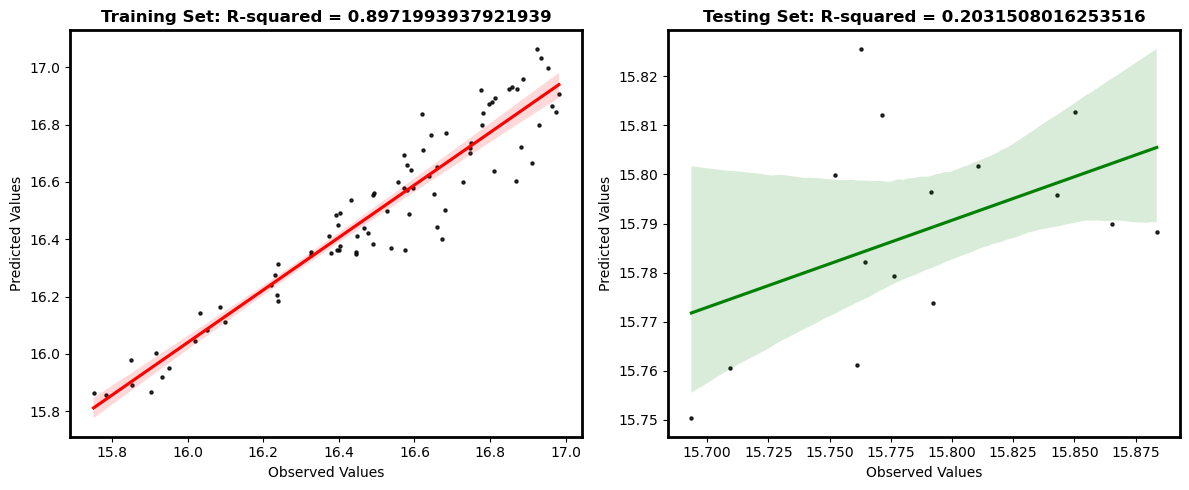

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))

# Plot the observed vs. predicted values for the training set
plt.subplot(1, 2, 1)
sns.regplot(x=results[best_index][1]['y_train_original'], y=results[best_index][1]['train_pred_original'], color='black', scatter_kws={'s':5}, line_kws={'color':'red'})
plt.xlabel('Observed Values')
plt.ylabel('Predicted Values')
title = results[best_index][1]['nse_train']
plt.title(f'Training Set: R-squared = {title}', fontweight='bold')

# Add bold border around the plot
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)

# Plot the observed vs. predicted values for the testing set
plt.subplot(1, 2, 2)
sns.regplot(x=results[best_index][1]['y_test_original'], y=results[best_index][1]['test_pred_original'], color='black', scatter_kws={'s':5}, line_kws={'color':'green'})
plt.xlabel('Observed Values')
plt.ylabel('Predicted Values')
title = results[best_index][1]['nse_test']
plt.title(f'Testing Set: NSE = {title}', fontweight='bold')

# Add bold border around the plot
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)

plt.tight_layout()
#plt.savefig("01_LSTM_fit_diagram.png", dpi=300)
plt.show()


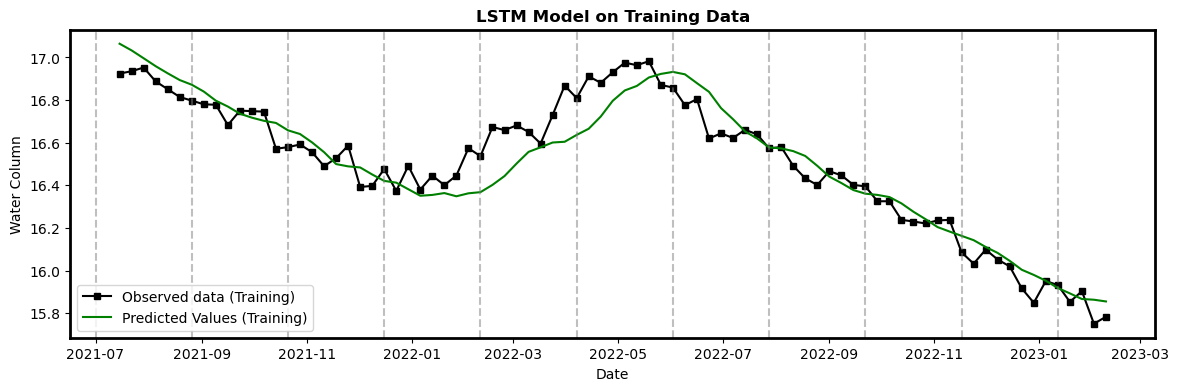

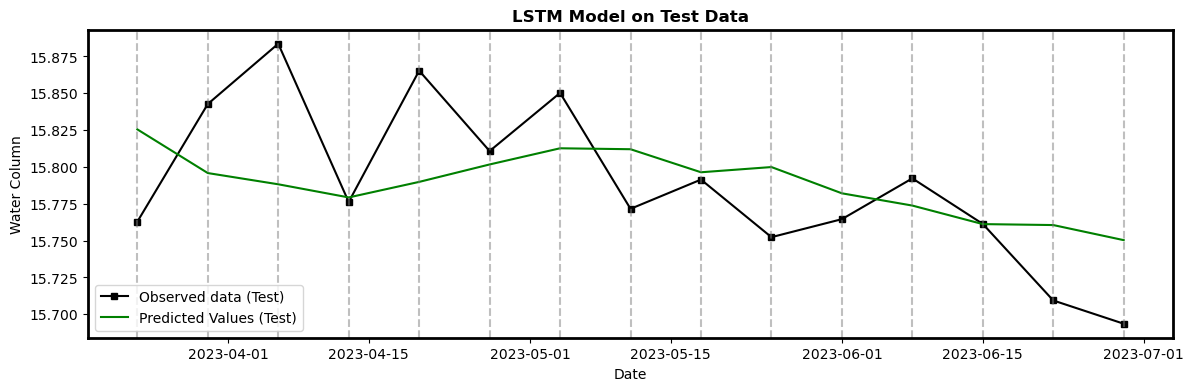

In [15]:
# First Plot for Training Data
plt.figure(figsize=(14, 4))

# Plot the predicted values for the training set
plt.plot(lstm_data.index[:split_index], results[best_index][1]['y_train_original'], label='Observed data (Training)', marker='s', markersize =4, color = 'black')

# Plot the predicted values for the training set
plt.plot(lstm_data.index[:split_index], results[best_index][1]['train_pred_original'], label='Predicted Values (Training)', color='green', linestyle='solid')

# Add vertical lines for each 8 weeks
current_date = pd.Timestamp('2021-07-01')
end_date = lstm_data.index[split_index]
while current_date <= end_date:
    plt.axvline(current_date, color='grey', linestyle='--', alpha=0.5)
    current_date += pd.DateOffset(weeks=8)

# Add bold border around the plot
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)

plt.xlabel('Date')
plt.ylabel('Water Column')
plt.title('LSTM Model on Training Data', fontweight='bold')
plt.legend(loc='lower left')
#plt.savefig("02_LSTM_forecast_diagram.png", dpi=300)
plt.show()

# Second Plot for Test Data
plt.figure(figsize=(14, 4))

# Plot the predicted values for the testing set
plt.plot(lstm_data.index[split_index+look_back:], results[best_index][1]['y_test_original'], label='Observed data (Test)', marker='s', markersize =4, color = 'black')

# Plot the predicted values for the testing set
plt.plot(lstm_data.index[split_index+look_back:], results[best_index][1]['test_pred_original'], label='Predicted Values (Test)', color='g', linestyle='solid')

# Add vertical lines for each 8 weeks
current_date = lstm_data.index[split_index+look_back]
end_date = pd.Timestamp('2023-07-01')
while current_date <= end_date:
    plt.axvline(current_date, color='grey', linestyle='--', alpha=0.5)
    current_date += pd.DateOffset(weeks=1)

# Add bold border around the plot
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)

plt.xlabel('Date')
plt.ylabel('Water Column')
plt.title('LSTM Model on Test Data', fontweight='bold')

plt.legend(loc='lower left')
#plt.savefig("03_LSTM_forecast_diagram.png", dpi=300)
plt.show()


## Fine Tuning Model

### With Dropoout Regularization

In [16]:
lstm_data = pd.read_csv('/Users/asur18/Desktop/MSc_Project_Data/My_Appoach/Data/LSTM.csv')

# Convert the 'Date' column to datetime
def convert_to_datetime(df):
    try:
        df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
    except:
        df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%y')
    return df

lstm_data = convert_to_datetime(lstm_data)

## Normalizing the data

In [17]:
lstm_data = lstm_data[['Date','Water Column']]
lstm_data.set_index('Date',inplace=True)

# # Get the 'Water Column' values and reshape them to a 2D array
values = lstm_data['Water Column'].values.reshape(-1, 1)

# # Normalize the data to the range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(values)



## Setting the random seeds for reproducibility and reshaping data for LSTM 

In [18]:
# Setting the random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define the lookback period
look_back = 5

# Reshape the data into sequences with a lookback period of 5
def create_sequences(data, look_back):
    X, Y = [], []
    for i in range(len(data)-look_back):
        a = data[i:(i+look_back), :]
        X.append(a)
        Y.append(data[i+look_back, 0])  # Predict the next water level
    return np.array(X), np.array(Y)

X, y = create_sequences(scaled_data, look_back)

In [19]:
# Split the reshaped data into training and testing datasets
split_index = int(0.85 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Print the shape of the reshaped data
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (83, 5, 1)
Shape of y_train: (83,)
Shape of X_test: (15, 5, 1)
Shape of y_test: (15,)


## Developing the Model Archtitecture

In [20]:
def run_loop(learning_rate, num_units, dropout_rate, batch_size, loop, num_epochs):
    
    for i in range(loop):
        
        # Start time capture
        start_time = time.time()
        
        # Define the LSTM model
        model = Sequential()
        # Define the LSTM model (Input Shape = lookback, number of features)
        model.add(LSTM(num_units, input_shape=(look_back, 1), kernel_initializer='glorot_uniform'))
        model.add(Dropout(dropout_rate))
        model.add(Dense(1,kernel_initializer='glorot_uniform'))
        optimizer = Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='mean_squared_error')

        # Train the model with validation data set to the test set
        history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, shuffle=False, verbose=2, validation_data=(X_test, y_test))

        # Display the model summary
        model.summary()

        # Evaluate the model on the validation data
        validation_loss = model.evaluate(X_test, y_test)
        print(f"Validation Loss: {validation_loss}")


        # Use the trained model to make predictions on the training and validation data
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)


        # Reshape the data to inverse transform
        train_pred_reshaped = np.zeros((len(train_pred), X_train.shape[2]))
        train_pred_reshaped[:,0] = train_pred[:,0].reshape(-1)
        test_pred_reshaped = np.zeros((len(test_pred), X_test.shape[2]))
        test_pred_reshaped[:,0] = test_pred[:,0].reshape(-1)

        # Inverse transform the predictions
        train_pred_original = scaler.inverse_transform(train_pred_reshaped)[:,0]
        test_pred_original = scaler.inverse_transform(test_pred_reshaped)[:,0]

        # Inverse transform the target values
        y_train_original = scaler.inverse_transform(np.hstack((y_train.reshape(-1,1), np.zeros((y_train.shape[0], X_train.shape[2]-1)))))[:,0]
        y_test_original = scaler.inverse_transform(np.hstack((y_test.reshape(-1,1), np.zeros((y_test.shape[0], X_test.shape[2]-1)))))[:,0]

        # Calculate the performance metrics
        mape_train = mean_absolute_percentage_error(y_train_original, train_pred_original)
        rmse_train = np.sqrt(mean_squared_error(y_train_original, train_pred_original))
        nse_train = nash_sutcliffe_efficiency(y_train_original, train_pred_original)

        mape_test = mean_absolute_percentage_error(y_test_original, test_pred_original)
        rmse_test = np.sqrt(mean_squared_error(y_test_original, test_pred_original))
        nse_test = nash_sutcliffe_efficiency(y_test_original, test_pred_original)
        
        # End time capture
        end_time = time.time()
        # Calculate elapsed time
        elapsed_time = end_time - start_time

        results.append((model, {"train_pred_original": train_pred_original, "test_pred_original": test_pred_original, "y_train_original": y_train_original, "y_test_original": y_test_original, "mape_train": mape_train, "rmse_train": rmse_train, "nse_train": nse_train, "mape_test": mape_test, "rmse_test": rmse_test, "nse_test": nse_test, "elapsed_time": elapsed_time}))
        
        

## Executing the model with 100 Iteration

In [25]:
results = []
# run_loop(lr, num_units, dropout_rate, batch_size, loop, num_epochs):
run_loop(0.001, 50, 0.5, 16, 100, 40)

Epoch 1/40
6/6 - 2s - loss: 0.3753 - val_loss: 0.0017 - 2s/epoch - 317ms/step
Epoch 2/40
6/6 - 0s - loss: 0.2510 - val_loss: 0.0021 - 47ms/epoch - 8ms/step
Epoch 3/40
6/6 - 0s - loss: 0.1444 - val_loss: 0.0071 - 46ms/epoch - 8ms/step
Epoch 4/40
6/6 - 0s - loss: 0.0778 - val_loss: 0.0170 - 44ms/epoch - 7ms/step
Epoch 5/40
6/6 - 0s - loss: 0.0469 - val_loss: 0.0313 - 42ms/epoch - 7ms/step
Epoch 6/40
6/6 - 0s - loss: 0.0263 - val_loss: 0.0433 - 41ms/epoch - 7ms/step
Epoch 7/40
6/6 - 0s - loss: 0.0209 - val_loss: 0.0442 - 41ms/epoch - 7ms/step
Epoch 8/40
6/6 - 0s - loss: 0.0227 - val_loss: 0.0369 - 40ms/epoch - 7ms/step
Epoch 9/40
6/6 - 0s - loss: 0.0244 - val_loss: 0.0287 - 41ms/epoch - 7ms/step
Epoch 10/40
6/6 - 0s - loss: 0.0153 - val_loss: 0.0232 - 41ms/epoch - 7ms/step
Epoch 11/40
6/6 - 0s - loss: 0.0211 - val_loss: 0.0206 - 41ms/epoch - 7ms/step
Epoch 12/40
6/6 - 0s - loss: 0.0179 - val_loss: 0.0196 - 39ms/epoch - 6ms/step
Epoch 13/40
6/6 - 0s - loss: 0.0210 - val_loss: 0.0194 - 39ms

1/1 [==============================] - 0s 22ms/step - loss: 0.0012
Validation Loss: 0.0012126362416893244
1/1 [==============================] - 0s 20ms/step
Epoch 1/40
6/6 - 2s - loss: 0.4421 - val_loss: 0.0020 - 2s/epoch - 302ms/step
Epoch 2/40
6/6 - 0s - loss: 0.2849 - val_loss: 0.0019 - 43ms/epoch - 7ms/step
Epoch 3/40
6/6 - 0s - loss: 0.1834 - val_loss: 0.0064 - 42ms/epoch - 7ms/step
Epoch 4/40
6/6 - 0s - loss: 0.1126 - val_loss: 0.0156 - 38ms/epoch - 6ms/step
Epoch 5/40
6/6 - 0s - loss: 0.0596 - val_loss: 0.0287 - 37ms/epoch - 6ms/step
Epoch 6/40
6/6 - 0s - loss: 0.0434 - val_loss: 0.0420 - 36ms/epoch - 6ms/step
Epoch 7/40
6/6 - 0s - loss: 0.0216 - val_loss: 0.0474 - 37ms/epoch - 6ms/step
Epoch 8/40
6/6 - 0s - loss: 0.0255 - val_loss: 0.0430 - 37ms/epoch - 6ms/step
Epoch 9/40
6/6 - 0s - loss: 0.0256 - val_loss: 0.0346 - 37ms/epoch - 6ms/step
Epoch 10/40
6/6 - 0s - loss: 0.0263 - val_loss: 0.0274 - 44ms/epoch - 7ms/step
Epoch 11/40
6/6 - 0s - loss: 0.0218 - val_loss: 0.0235 - 49ms

Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 21ms/step - loss: 0.0012
Validation Loss: 0.0011953149223700166
1/1 [==============================] - 0s 19ms/step
Epoch 1/40
6/6 - 2s - loss: 0.3337 - val_loss: 0.0015 - 2s/epoch - 300ms/step
Epoch 2/40
6/6 - 0s - loss: 0.2211 - val_loss: 0.0025 - 42ms/epoch - 7ms/step
Epoch 3/40
6/6 - 0s - loss: 0.1292 - val_loss: 0.0083 - 43ms/epoch - 7ms/step
Epoch 4/40
6/6 - 0s - loss: 0.0616 - val_loss: 0.0190 - 38ms/epoch - 6ms/step
Epoch 5/40
6/6 - 0s - loss: 0.0280 - val_loss: 0.0313 - 37ms/epoch - 6ms/step
Epoch 6/40
6/6 - 0s - loss: 0.0252 - val_loss: 0.0387 - 37ms/epoch - 6ms/step
Epoch 7/40
6/6 - 0s - loss: 0.0164 - val_loss: 0.0363 - 37ms/epoch - 6ms/step
Epoch 8/40
6/6 - 0s - loss: 0.0206 - val_loss: 0.0299 - 37ms/epoch - 6ms/step
Epoch 9/40
6/6 - 0s - loss: 0.0208 - val_loss: 0.0236 - 37ms/epoch - 6ms/step
Epoc

                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 21ms/step - loss: 0.0012
Validation Loss: 0.0011811190051957965
1/1 [==============================] - 0s 19ms/step
Epoch 1/40
6/6 - 2s - loss: 0.4274 - val_loss: 0.0018 - 2s/epoch - 314ms/step
Epoch 2/40
6/6 - 0s - loss: 0.2719 - val_loss: 0.0022 - 51ms/epoch - 8ms/step
Epoch 3/40
6/6 - 0s - loss: 0.1623 - val_loss: 0.0073 - 45ms/epoch - 7ms/step
Epoch 4/40
6/6 - 0s - loss: 0.0856 - val_loss: 0.0170 - 39ms/epoch - 7ms/step
Epoch 5/40
6/6 - 0s - loss: 0.0502 - val_loss: 0.0298 - 37ms/epoch - 6ms/step
Epoch 6/40
6/6 - 0s - loss: 0.0287 - val_loss: 0.0403 - 39ms/epoch - 7ms/step
Epoch 7/40
6/6 - 0s - loss: 0.0216 - val_loss: 0.0426 - 38ms/epoch - 6ms/step
Epoch 8/40
6/6 - 0s - loss: 0.0226 - val_loss: 0.0369 - 38ms/epoch - 6ms/step
Epoch 9/40
6/6 -

                                                                 
 dense_67 (Dense)            (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 21ms/step - loss: 0.0013
Validation Loss: 0.0012762821279466152
1/1 [==============================] - 0s 19ms/step
Epoch 1/40
6/6 - 2s - loss: 0.3670 - val_loss: 0.0015 - 2s/epoch - 298ms/step
Epoch 2/40
6/6 - 0s - loss: 0.2286 - val_loss: 0.0034 - 44ms/epoch - 7ms/step
Epoch 3/40
6/6 - 0s - loss: 0.1311 - val_loss: 0.0119 - 42ms/epoch - 7ms/step
Epoch 4/40
6/6 - 0s - loss: 0.0546 - val_loss: 0.0265 - 37ms/epoch - 6ms/step
Epoch 5/40
6/6 - 0s - loss: 0.0284 - val_loss: 0.0421 - 37ms/epoch - 6ms/step
Epoch 6/40
6/6 - 0s - loss: 0.0308 - val_loss: 0.0493 - 36ms/epoch - 6ms/step
Epoch 7/40
6/6 - 0s - loss: 0.0198 - val

                                                                 
 dropout_39 (Dropout)        (None, 50)                0         
                                                                 
 dense_69 (Dense)            (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 21ms/step - loss: 0.0014
Validation Loss: 0.001399361644871533
1/1 [==============================] - 0s 19ms/step
Epoch 1/40
6/6 - 2s - loss: 0.3033 - val_loss: 0.0013 - 2s/epoch - 293ms/step
Epoch 2/40
6/6 - 0s - loss: 0.1795 - val_loss: 0.0041 - 45ms/epoch - 8ms/step
Epoch 3/40
6/6 - 0s - loss: 0.0787 - val_loss: 0.0142 - 42ms/epoch - 7ms/step
Epoch 4/40
6/6 - 0s - loss: 0.0367 - val_loss: 0.0298 - 37ms/epoch - 6ms/step
Epoch 5/40
6/6 - 0s - loss: 0.0224 - val_loss: 0.0408 - 37ms/epoc

 lstm_71 (LSTM)              (None, 50)                10400     
                                                                 
 dropout_41 (Dropout)        (None, 50)                0         
                                                                 
 dense_71 (Dense)            (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 24ms/step - loss: 0.0012
Validation Loss: 0.0011511956108734012
1/1 [==============================] - 0s 21ms/step
Epoch 1/40
6/6 - 2s - loss: 0.5861 - val_loss: 0.0034 - 2s/epoch - 294ms/step
Epoch 2/40
6/6 - 0s - loss: 0.4361 - val_loss: 0.0015 - 44ms/epoch - 7ms/step
Epoch 3/40
6/6 - 0s - loss: 0.3112 - val_loss: 0.0026 - 42ms/epoch - 7ms/step
Epoch 4/40
6/6 - 0s - loss: 0.2221 - val_loss: 0.0068 - 39ms/epoch - 6ms/ste

Model: "sequential_73"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_73 (LSTM)              (None, 50)                10400     
                                                                 
 dropout_43 (Dropout)        (None, 50)                0         
                                                                 
 dense_73 (Dense)            (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 23ms/step - loss: 0.0013
Validation Loss: 0.0012629030970856547
1/1 [==============================] - 0s 21ms/step
Epoch 1/40
6/6 - 2s - loss: 0.3936 - val_loss: 0.0017 - 2s/epoch - 298ms/step
Epoch 2/40
6/6 - 0s - loss: 0.2301 - val_loss: 0.0022 - 42ms/epoch - 7ms/step

Epoch 39/40
6/6 - 0s - loss: 0.0098 - val_loss: 0.0011 - 37ms/epoch - 6ms/step
Epoch 40/40
6/6 - 0s - loss: 0.0076 - val_loss: 0.0012 - 36ms/epoch - 6ms/step
Model: "sequential_75"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_75 (LSTM)              (None, 50)                10400     
                                                                 
 dropout_45 (Dropout)        (None, 50)                0         
                                                                 
 dense_75 (Dense)            (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 21ms/step - loss: 0.0012
Validation Loss: 0.0011767622781917453
1/1 [==============================] - 0s 19ms/st

Epoch 37/40
6/6 - 0s - loss: 0.0117 - val_loss: 0.0012 - 36ms/epoch - 6ms/step
Epoch 38/40
6/6 - 0s - loss: 0.0106 - val_loss: 0.0012 - 36ms/epoch - 6ms/step
Epoch 39/40
6/6 - 0s - loss: 0.0114 - val_loss: 0.0011 - 36ms/epoch - 6ms/step
Epoch 40/40
6/6 - 0s - loss: 0.0084 - val_loss: 0.0011 - 36ms/epoch - 6ms/step
Model: "sequential_77"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_77 (LSTM)              (None, 50)                10400     
                                                                 
 dropout_47 (Dropout)        (None, 50)                0         
                                                                 
 dense_77 (Dense)            (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_______________________________________________________________

Epoch 35/40
6/6 - 0s - loss: 0.0118 - val_loss: 0.0011 - 36ms/epoch - 6ms/step
Epoch 36/40
6/6 - 0s - loss: 0.0099 - val_loss: 0.0011 - 36ms/epoch - 6ms/step
Epoch 37/40
6/6 - 0s - loss: 0.0134 - val_loss: 0.0011 - 36ms/epoch - 6ms/step
Epoch 38/40
6/6 - 0s - loss: 0.0107 - val_loss: 0.0011 - 36ms/epoch - 6ms/step
Epoch 39/40
6/6 - 0s - loss: 0.0139 - val_loss: 0.0011 - 36ms/epoch - 6ms/step
Epoch 40/40
6/6 - 0s - loss: 0.0088 - val_loss: 0.0012 - 37ms/epoch - 6ms/step
Model: "sequential_79"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_79 (LSTM)              (None, 50)                10400     
                                                                 
 dropout_49 (Dropout)        (None, 50)                0         
                                                                 
 dense_79 (Dense)            (None, 1)                 51        
                                         

Epoch 33/40
6/6 - 0s - loss: 0.0120 - val_loss: 0.0014 - 42ms/epoch - 7ms/step
Epoch 34/40
6/6 - 0s - loss: 0.0138 - val_loss: 0.0012 - 38ms/epoch - 6ms/step
Epoch 35/40
6/6 - 0s - loss: 0.0096 - val_loss: 0.0011 - 38ms/epoch - 6ms/step
Epoch 36/40
6/6 - 0s - loss: 0.0118 - val_loss: 0.0011 - 37ms/epoch - 6ms/step
Epoch 37/40
6/6 - 0s - loss: 0.0126 - val_loss: 0.0011 - 39ms/epoch - 6ms/step
Epoch 38/40
6/6 - 0s - loss: 0.0123 - val_loss: 0.0011 - 37ms/epoch - 6ms/step
Epoch 39/40
6/6 - 0s - loss: 0.0110 - val_loss: 0.0011 - 37ms/epoch - 6ms/step
Epoch 40/40
6/6 - 0s - loss: 0.0084 - val_loss: 0.0011 - 37ms/epoch - 6ms/step
Model: "sequential_81"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_81 (LSTM)              (None, 50)                10400     
                                                                 
 dropout_51 (Dropout)        (None, 50)                0         
               

Epoch 31/40
6/6 - 0s - loss: 0.0149 - val_loss: 0.0034 - 37ms/epoch - 6ms/step
Epoch 32/40
6/6 - 0s - loss: 0.0175 - val_loss: 0.0033 - 36ms/epoch - 6ms/step
Epoch 33/40
6/6 - 0s - loss: 0.0129 - val_loss: 0.0036 - 36ms/epoch - 6ms/step
Epoch 34/40
6/6 - 0s - loss: 0.0164 - val_loss: 0.0030 - 36ms/epoch - 6ms/step
Epoch 35/40
6/6 - 0s - loss: 0.0100 - val_loss: 0.0023 - 36ms/epoch - 6ms/step
Epoch 36/40
6/6 - 0s - loss: 0.0138 - val_loss: 0.0020 - 36ms/epoch - 6ms/step
Epoch 37/40
6/6 - 0s - loss: 0.0130 - val_loss: 0.0019 - 37ms/epoch - 6ms/step
Epoch 38/40
6/6 - 0s - loss: 0.0122 - val_loss: 0.0021 - 36ms/epoch - 6ms/step
Epoch 39/40
6/6 - 0s - loss: 0.0126 - val_loss: 0.0021 - 36ms/epoch - 6ms/step
Epoch 40/40
6/6 - 0s - loss: 0.0101 - val_loss: 0.0017 - 36ms/epoch - 6ms/step
Model: "sequential_83"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_83 (LSTM)              (None, 50)                

Epoch 29/40
6/6 - 0s - loss: 0.0123 - val_loss: 0.0049 - 37ms/epoch - 6ms/step
Epoch 30/40
6/6 - 0s - loss: 0.0122 - val_loss: 0.0039 - 36ms/epoch - 6ms/step
Epoch 31/40
6/6 - 0s - loss: 0.0159 - val_loss: 0.0035 - 36ms/epoch - 6ms/step
Epoch 32/40
6/6 - 0s - loss: 0.0162 - val_loss: 0.0033 - 36ms/epoch - 6ms/step
Epoch 33/40
6/6 - 0s - loss: 0.0126 - val_loss: 0.0033 - 36ms/epoch - 6ms/step
Epoch 34/40
6/6 - 0s - loss: 0.0146 - val_loss: 0.0028 - 36ms/epoch - 6ms/step
Epoch 35/40
6/6 - 0s - loss: 0.0102 - val_loss: 0.0023 - 36ms/epoch - 6ms/step
Epoch 36/40
6/6 - 0s - loss: 0.0128 - val_loss: 0.0018 - 36ms/epoch - 6ms/step
Epoch 37/40
6/6 - 0s - loss: 0.0134 - val_loss: 0.0017 - 36ms/epoch - 6ms/step
Epoch 38/40
6/6 - 0s - loss: 0.0138 - val_loss: 0.0019 - 36ms/epoch - 6ms/step
Epoch 39/40
6/6 - 0s - loss: 0.0147 - val_loss: 0.0019 - 36ms/epoch - 6ms/step
Epoch 40/40
6/6 - 0s - loss: 0.0120 - val_loss: 0.0017 - 36ms/epoch - 6ms/step
Model: "sequential_85"
_____________________________

Epoch 27/40
6/6 - 0s - loss: 0.0134 - val_loss: 0.0036 - 36ms/epoch - 6ms/step
Epoch 28/40
6/6 - 0s - loss: 0.0185 - val_loss: 0.0037 - 37ms/epoch - 6ms/step
Epoch 29/40
6/6 - 0s - loss: 0.0142 - val_loss: 0.0034 - 36ms/epoch - 6ms/step
Epoch 30/40
6/6 - 0s - loss: 0.0163 - val_loss: 0.0029 - 36ms/epoch - 6ms/step
Epoch 31/40
6/6 - 0s - loss: 0.0155 - val_loss: 0.0025 - 36ms/epoch - 6ms/step
Epoch 32/40
6/6 - 0s - loss: 0.0139 - val_loss: 0.0023 - 36ms/epoch - 6ms/step
Epoch 33/40
6/6 - 0s - loss: 0.0127 - val_loss: 0.0023 - 37ms/epoch - 6ms/step
Epoch 34/40
6/6 - 0s - loss: 0.0159 - val_loss: 0.0020 - 36ms/epoch - 6ms/step
Epoch 35/40
6/6 - 0s - loss: 0.0106 - val_loss: 0.0016 - 36ms/epoch - 6ms/step
Epoch 36/40
6/6 - 0s - loss: 0.0150 - val_loss: 0.0015 - 37ms/epoch - 6ms/step
Epoch 37/40
6/6 - 0s - loss: 0.0146 - val_loss: 0.0015 - 36ms/epoch - 6ms/step
Epoch 38/40
6/6 - 0s - loss: 0.0130 - val_loss: 0.0015 - 36ms/epoch - 6ms/step
Epoch 39/40
6/6 - 0s - loss: 0.0152 - val_loss: 0.00

Epoch 25/40
6/6 - 0s - loss: 0.0155 - val_loss: 0.0047 - 39ms/epoch - 7ms/step
Epoch 26/40
6/6 - 0s - loss: 0.0155 - val_loss: 0.0038 - 37ms/epoch - 6ms/step
Epoch 27/40
6/6 - 0s - loss: 0.0120 - val_loss: 0.0033 - 36ms/epoch - 6ms/step
Epoch 28/40
6/6 - 0s - loss: 0.0135 - val_loss: 0.0033 - 37ms/epoch - 6ms/step
Epoch 29/40
6/6 - 0s - loss: 0.0130 - val_loss: 0.0033 - 36ms/epoch - 6ms/step
Epoch 30/40
6/6 - 0s - loss: 0.0147 - val_loss: 0.0027 - 36ms/epoch - 6ms/step
Epoch 31/40
6/6 - 0s - loss: 0.0150 - val_loss: 0.0025 - 36ms/epoch - 6ms/step
Epoch 32/40
6/6 - 0s - loss: 0.0173 - val_loss: 0.0024 - 36ms/epoch - 6ms/step
Epoch 33/40
6/6 - 0s - loss: 0.0138 - val_loss: 0.0022 - 36ms/epoch - 6ms/step
Epoch 34/40
6/6 - 0s - loss: 0.0148 - val_loss: 0.0018 - 37ms/epoch - 6ms/step
Epoch 35/40
6/6 - 0s - loss: 0.0150 - val_loss: 0.0016 - 36ms/epoch - 6ms/step
Epoch 36/40
6/6 - 0s - loss: 0.0124 - val_loss: 0.0015 - 37ms/epoch - 6ms/step
Epoch 37/40
6/6 - 0s - loss: 0.0155 - val_loss: 0.00

In [26]:
#print(results)

best_index = 0
best_score = results[0][1]['nse_test']
for i in range(len(results)):
    if (results[i][1]['nse_test'] > best_score):
        best_score = results[i][1]['nse_test']
        best_index = i
        
        
#print(best_index, best_score)

In [27]:
# Showing the best model metrics
best_metrics = results[best_index][1]
best_time = best_metrics['elapsed_time']

print(f"Best Model Index: {best_index}")
print(f"Convergence Time: {best_time:.4f} seconds")


print(f"Training MAPE: {best_metrics['mape_train']:.4f}")
print(f"Training RMSE: {best_metrics['rmse_train']:.4f}")
print(f"Training NSE: {best_metrics['nse_train']:.4f}")
print('\n')
print(f"Testing MAPE: {best_metrics['mape_test']:.4f}")
print(f"Testing RMSE: {best_metrics['rmse_test']:.4f}")
print(f"Testing NSE: {best_metrics['nse_test']:.4f}")


Best Model Index: 81
Convergence Time: 5.8764 seconds
Training MAPE: 0.4635
Training RMSE: 0.0969
Training NSE: 0.9061


Testing MAPE: 0.2387
Testing RMSE: 0.0464
Testing NSE: 0.2158


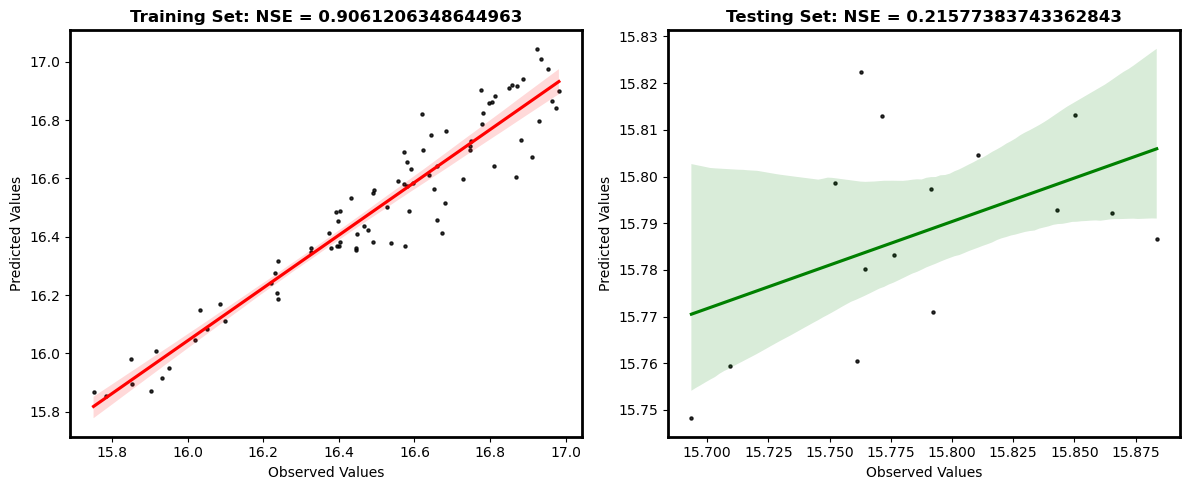

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))

# Plot the observed vs. predicted values for the training set
plt.subplot(1, 2, 1)
sns.regplot(x=results[best_index][1]['y_train_original'], y=results[best_index][1]['train_pred_original'], color='black', scatter_kws={'s':5}, line_kws={'color':'red'})
plt.xlabel('Observed Values')
plt.ylabel('Predicted Values')
title = results[best_index][1]['nse_train']
plt.title(f'Training Set: NSE = {title}', fontweight='bold')

# Add bold border around the plot
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)

# Plot the observed vs. predicted values for the testing set
plt.subplot(1, 2, 2)
sns.regplot(x=results[best_index][1]['y_test_original'], y=results[best_index][1]['test_pred_original'], color='black', scatter_kws={'s':5}, line_kws={'color':'green'})
plt.xlabel('Observed Values')
plt.ylabel('Predicted Values')
title = results[best_index][1]['nse_test']
plt.title(f'Testing Set: NSE = {title}', fontweight='bold')

# Add bold border around the plot
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)

plt.tight_layout()
#plt.savefig("01_LSTM_fit_diagram.png", dpi=300)
plt.show()


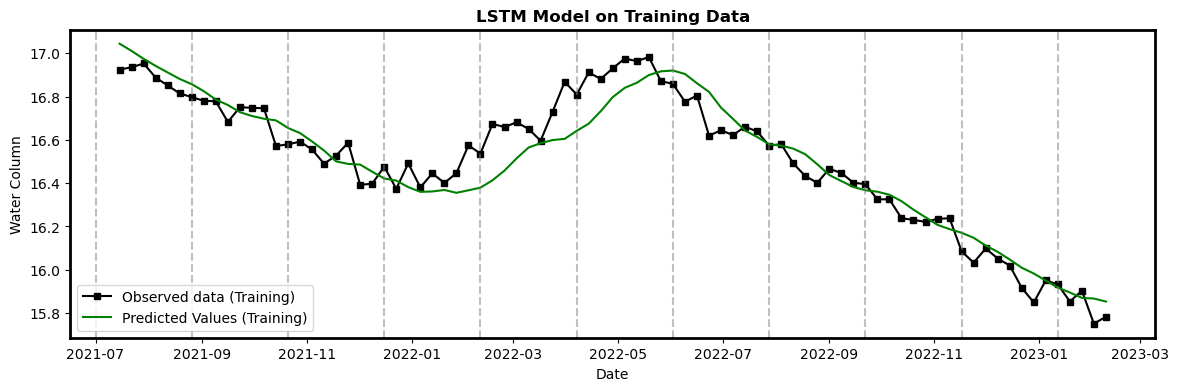

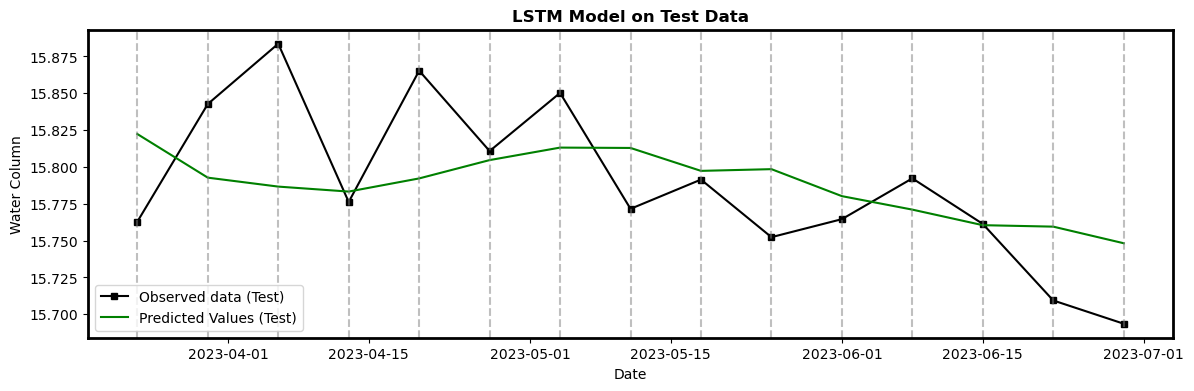

In [30]:
# First Plot for Training Data
plt.figure(figsize=(14, 4))

# Plot the predicted values for the training set
plt.plot(lstm_data.index[:split_index], results[best_index][1]['y_train_original'], label='Observed data (Training)', marker='s', markersize =4, color = 'black')

# Plot the predicted values for the training set
plt.plot(lstm_data.index[:split_index], results[best_index][1]['train_pred_original'], label='Predicted Values (Training)', color='green', linestyle='solid')

# Add vertical lines for each 8 weeks
current_date = pd.Timestamp('2021-07-01')
end_date = lstm_data.index[split_index]
while current_date <= end_date:
    plt.axvline(current_date, color='grey', linestyle='--', alpha=0.5)
    current_date += pd.DateOffset(weeks=8)

# Add bold border around the plot
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)

plt.xlabel('Date')
plt.ylabel('Water Column')
plt.title('LSTM Model on Training Data', fontweight='bold')
plt.legend(loc='lower left')
#plt.savefig("02_LSTM_forecast_diagram.png", dpi=300)
plt.show()

# Second Plot for Test Data
plt.figure(figsize=(14, 4))

# Plot the predicted values for the testing set
plt.plot(lstm_data.index[split_index+look_back:], results[best_index][1]['y_test_original'], label='Observed data (Test)', marker='s', markersize =4, color = 'black')

# Plot the predicted values for the testing set
plt.plot(lstm_data.index[split_index+look_back:], results[best_index][1]['test_pred_original'], label='Predicted Values (Test)', color='g', linestyle='solid')

# Add vertical lines for each 8 weeks
current_date = lstm_data.index[split_index+look_back]
end_date = pd.Timestamp('2023-07-01')
while current_date <= end_date:
    plt.axvline(current_date, color='grey', linestyle='--', alpha=0.5)
    current_date += pd.DateOffset(weeks=1)

# Add bold border around the plot
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)

plt.xlabel('Date')
plt.ylabel('Water Column')
plt.title('LSTM Model on Test Data', fontweight='bold')

plt.legend(loc='lower left')
#plt.savefig("03_LSTM_forecast_diagram.png", dpi=300)
plt.show()
